# Test GP formulation as batch: Multi-Inputs, Multi-Outputs

## Description

This script trains a batch GP model of size (n_GP_outputs,n_GP_models_in_batch), with a training input of size (n_GP_outputs,n_GP_models_in_batch,n_offline_data,n_GP_inputs) and a training output of size (n_GP_outputs,n_GP_models_in_batch,n_offline_data). 

The dimensions are based on the fact that the true function $g$ is a function of 3 inputs (n_GP_inputs=3) and 2 outputs (n_GP_ouputs=2). Instead of training a single GP model, we train n_GP_outputs * n_GP_models_in_batch models, all combined into a single batch. 

In principle, the different GP models along the dimensions n_GP_models_in_batch and n_GP_outputs could have different hyperparameters after the training/hyperparameter optimisation. Our setup requires however than all GP models along the dimension n_GP_models_in_batch have the same hyperparameters. After training, we therefore set the hyperparameter of the GP along the dimension n_GP_models_in_batch to be the same as the hyperparameters of the first GP along this dimension. This leads to two (n_GP_outputs=2) groups of GP models, with 2 different sets of hyperparameters, one set per GP output dimension. We therefore learn the two output of $g$ independently.

The last part of the script tests the GP updates of a single GP along the n_GP_models_in_batch dimension.

## 1. Create training data and train model

In [1]:
import torch
import gpytorch
import math
from matplotlib import pyplot as plt

# Evaluate the true function g(x) = g(\phi,v1,v2) with two outputs
def eval_g(phi, v1, v2):
    return v1 * (torch.cos(phi) - 1) - v2 * (torch.sin(phi) - phi), v1 * torch.sin(phi) + v2 * (torch.cos(phi) - 1)

# Generate training inputs according to a grid defined by the range of the arguments \phi,v1 and v2, and a number of data points along each dimension.
def generate_training_positions(phi_range, v1_range, v2_range, num_points):
    phi_points = torch.linspace(phi_range[0], phi_range[1], num_points)
    v1_points = torch.linspace(v1_range[0], v1_range[1], num_points)
    v2_points = torch.linspace(v2_range[0], v2_range[1], num_points)
    phi_grid, v1_grid, v2_grid = torch.meshgrid(phi_points, v1_points, v2_points, indexing='ij')
    X_train_offline = torch.stack([phi_grid.flatten(), v1_grid.flatten(), v2_grid.flatten()], dim=1)
    return X_train_offline

# Generate outputs of the function g for all n points in X_train (size of X_train is (n,n_g_inputs))
def generate_g_outputs(X_train, noise_size):
    n_train = X_train.shape[0]
    y_train = torch.zeros(n_train, 2)
    for i in range(n_train):
        g_value1, g_value2 = eval_g(X_train[i, 0], X_train[i, 1], X_train[i, 2])
        noise_value1 = (torch.rand(1) - 0.5) * noise_size
        noise_value2 = (torch.rand(1) - 0.5) * noise_size
        y_train[i, 0] = g_value1 + noise_value1
        y_train[i, 1] = g_value2 + noise_value2
    return y_train

# Generate training data
torch.manual_seed(0)
phi_range = (-torch.pi / 8, torch.pi / 8)
v1_range = (0.95, 1.05)
v2_range = (0.95, 1.05)
n_pts_per_dim = 9

X_train_offline = generate_training_positions(phi_range, v1_range, v2_range, n_pts_per_dim)
n_offline_data = X_train_offline.shape[0]
n_GP_inputs = X_train_offline.shape[1]
noise_size = 0.001
Y_train_offline = generate_g_outputs(X_train_offline, noise_size)

# Prepare for batch GP
n_gp_models_in_batch = 8  # Number of GP models in the batch
n_data_points_in_batch = 1000
n_GP_outputs = 2  # Two outputs

X_train_batch = torch.zeros((n_GP_outputs, n_gp_models_in_batch, n_data_points_in_batch, n_GP_inputs))
Y_train_batch = torch.full((n_GP_outputs, n_gp_models_in_batch, n_data_points_in_batch), float('nan'))

# Copy the original data into the new tensors
X_train_batch[:, :, :n_offline_data, :] = X_train_offline.tile(n_GP_outputs, n_gp_models_in_batch, 1, 1)
Y_train_batch[0, :, :n_offline_data] = Y_train_offline[:, 0].tile(n_gp_models_in_batch, 1)
Y_train_batch[1, :, :n_offline_data] = Y_train_offline[:, 1].tile(n_gp_models_in_batch, 1)

batch_shape = torch.Size([n_GP_outputs, n_gp_models_in_batch])

# Define the GP model
class BatchGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, batch_shape):
        super(BatchGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=batch_shape)
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=batch_shape),
            batch_shape=batch_shape
        )


    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood(batch_shape=batch_shape)
gp_models_as_batch = BatchGPModel(X_train_batch, Y_train_batch, likelihood, batch_shape)

# Train the model
with gpytorch.settings.observation_nan_policy("mask"):
    
    # Training mode
    gp_models_as_batch.train()
    likelihood.train()

    optimizer = torch.optim.Adam(gp_models_as_batch.parameters(), lr=0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp_models_as_batch)

    training_iterations = 100
    for i in range(training_iterations):
        optimizer.zero_grad()
        output = gp_models_as_batch(X_train_batch)
        loss = -mll(output, Y_train_batch).sum()  # Summing the losses across the batch dimensions
        loss.backward()
        print(f'Iter {i + 1}/{training_iterations} - Loss: {loss.item():.3f}')
        optimizer.step()

    # Set the model to evaluation mode
    gp_models_as_batch.eval()
    likelihood.eval()

Iter 1/100 - Loss: 8.705
Iter 2/100 - Loss: 8.275
Iter 3/100 - Loss: 7.838
Iter 4/100 - Loss: 7.392
Iter 5/100 - Loss: 6.937
Iter 6/100 - Loss: 6.475
Iter 7/100 - Loss: 6.003
Iter 8/100 - Loss: 5.524
Iter 9/100 - Loss: 5.037
Iter 10/100 - Loss: 4.542
Iter 11/100 - Loss: 4.039
Iter 12/100 - Loss: 3.529
Iter 13/100 - Loss: 3.011
Iter 14/100 - Loss: 2.486
Iter 15/100 - Loss: 1.954
Iter 16/100 - Loss: 1.416
Iter 17/100 - Loss: 0.872
Iter 18/100 - Loss: 0.322
Iter 19/100 - Loss: -0.233
Iter 20/100 - Loss: -0.793
Iter 21/100 - Loss: -1.357
Iter 22/100 - Loss: -1.925
Iter 23/100 - Loss: -2.497
Iter 24/100 - Loss: -3.073
Iter 25/100 - Loss: -3.653
Iter 26/100 - Loss: -4.235
Iter 27/100 - Loss: -4.820
Iter 28/100 - Loss: -5.407
Iter 29/100 - Loss: -5.996
Iter 30/100 - Loss: -6.587
Iter 31/100 - Loss: -7.180
Iter 32/100 - Loss: -7.773
Iter 33/100 - Loss: -8.367
Iter 34/100 - Loss: -8.962
Iter 35/100 - Loss: -9.558
Iter 36/100 - Loss: -10.154
Iter 37/100 - Loss: -10.750
Iter 38/100 - Loss: -11.34

### Check hyperparameters: they are probably slightly different for each GP models

In [2]:
# Check hyperparameters of the GP models
def print_hyperparameters(gp_model):
    for name, param in gp_model.named_parameters():
        print(f"{name}: {param.data}")

print("Hyperparameters of the GP models:")
print_hyperparameters(gp_models_as_batch)

# Check hyperparameters of the likelihood
print("\nHyperparameters of the likelihood:")
for name, param in likelihood.named_parameters():
    print(f"{name}: {param.data}")


Hyperparameters of the GP models:
likelihood.noise_covar.raw_noise: tensor([[[-9.7698],
         [-9.7698],
         [-9.7698],
         [-9.7698],
         [-9.7698],
         [-9.7698],
         [-9.7698],
         [-9.7698]],

        [[-9.7676],
         [-9.7676],
         [-9.7676],
         [-9.7676],
         [-9.7676],
         [-9.7676],
         [-9.7676],
         [-9.7676]]])
mean_module.raw_constant: tensor([[-0.2103, -0.2108, -0.2107, -0.2106, -0.2103, -0.2108, -0.2107, -0.2106],
        [-0.6753, -0.6747, -0.6748, -0.6759, -0.6753, -0.6747, -0.6748, -0.6759]])
covar_module.raw_outputscale: tensor([[-4.1571, -4.1571, -4.1571, -4.1571, -4.1571, -4.1571, -4.1571, -4.1571],
        [ 0.5900,  0.5897,  0.5888,  0.5914,  0.5900,  0.5897,  0.5888,  0.5914]])
covar_module.base_kernel.raw_lengthscale: tensor([[[[-0.0218]],

         [[-0.0218]],

         [[-0.0217]],

         [[-0.0217]],

         [[-0.0218]],

         [[-0.0218]],

         [[-0.0217]],

         [[-0.0217]

### Set the same hyperparameters across the different GP models

In [3]:
# Function to set hyperparameters of all batch dimensions to be the same as the first batch dimension
def set_hyperparameters_to_first_dimension(model, likelihood):
    with torch.no_grad():
        for output in range(model.mean_module.raw_constant.shape[0]):
            # Mean parameter
            model.mean_module.raw_constant[output].copy_(model.mean_module.raw_constant[output, 0].expand_as(model.mean_module.raw_constant[output]))

            # Covariance parameters
            model.covar_module.raw_outputscale[output].copy_(model.covar_module.raw_outputscale[output, 0].expand_as(model.covar_module.raw_outputscale[output]))
            model.covar_module.base_kernel.raw_lengthscale[output].copy_(model.covar_module.base_kernel.raw_lengthscale[output, 0].expand_as(model.covar_module.base_kernel.raw_lengthscale[output]))

            # Noise parameter
            likelihood.noise_covar.raw_noise[output].copy_(likelihood.noise_covar.raw_noise[output, 0].expand_as(likelihood.noise_covar.raw_noise[output]))

# Set hyperparameters
set_hyperparameters_to_first_dimension(gp_models_as_batch, likelihood)

### Check the hyperparameters again: we have now 2 sets of the same hyperparameters, one set per output dimension of g

In [4]:
# Check hyperparameters of the GP models
def print_hyperparameters(gp_model):
    for name, param in gp_model.named_parameters():
        print(f"{name}: {param.data}")

print("Hyperparameters of the GP models:")
print_hyperparameters(gp_models_as_batch)

# Check hyperparameters of the likelihood
print("\nHyperparameters of the likelihood:")
for name, param in likelihood.named_parameters():
    print(f"{name}: {param.data}")

# Print the hyperparameters, not in there "raw" form
print("Mean constant:", gp_models_as_batch.mean_module.constant)
print("Output scale:", gp_models_as_batch.covar_module.outputscale)
print("Lengthscale:", gp_models_as_batch.covar_module.base_kernel.lengthscale)
print("Noise:", likelihood.noise_covar.noise)

Hyperparameters of the GP models:
likelihood.noise_covar.raw_noise: tensor([[[-9.7698],
         [-9.7698],
         [-9.7698],
         [-9.7698],
         [-9.7698],
         [-9.7698],
         [-9.7698],
         [-9.7698]],

        [[-9.7676],
         [-9.7676],
         [-9.7676],
         [-9.7676],
         [-9.7676],
         [-9.7676],
         [-9.7676],
         [-9.7676]]])
mean_module.raw_constant: tensor([[-0.2103, -0.2103, -0.2103, -0.2103, -0.2103, -0.2103, -0.2103, -0.2103],
        [-0.6753, -0.6753, -0.6753, -0.6753, -0.6753, -0.6753, -0.6753, -0.6753]])
covar_module.raw_outputscale: tensor([[-4.1571, -4.1571, -4.1571, -4.1571, -4.1571, -4.1571, -4.1571, -4.1571],
        [ 0.5900,  0.5900,  0.5900,  0.5900,  0.5900,  0.5900,  0.5900,  0.5900]])
covar_module.base_kernel.raw_lengthscale: tensor([[[[-0.0218]],

         [[-0.0218]],

         [[-0.0218]],

         [[-0.0218]],

         [[-0.0218]],

         [[-0.0218]],

         [[-0.0218]],

         [[-0.0218]

## 2. Plot the GP models

/mnt/c/users/mathi/documents/zo-gpmpc/env/lib/python3.10/site-packages/gpytorch/models/exact_prediction_strategies.py:278: RuntimeWarning: Observation NaN policy 'fill' makes the kernel matrix dense during exact prediction.
  warnings.warn(


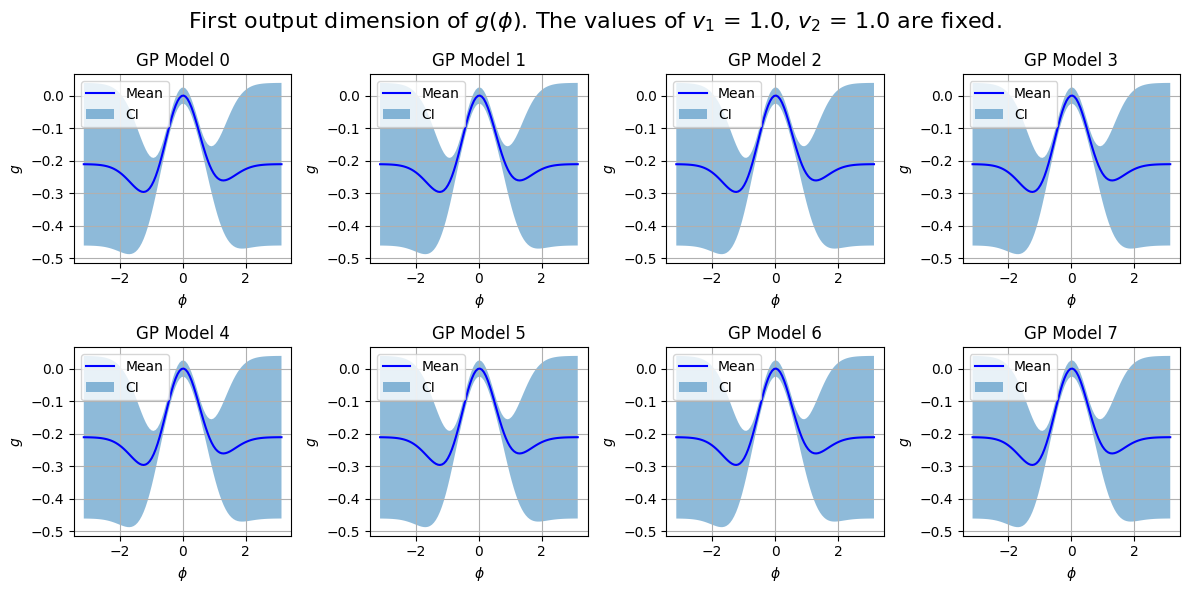

/mnt/c/users/mathi/documents/zo-gpmpc/env/lib/python3.10/site-packages/gpytorch/distributions/multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


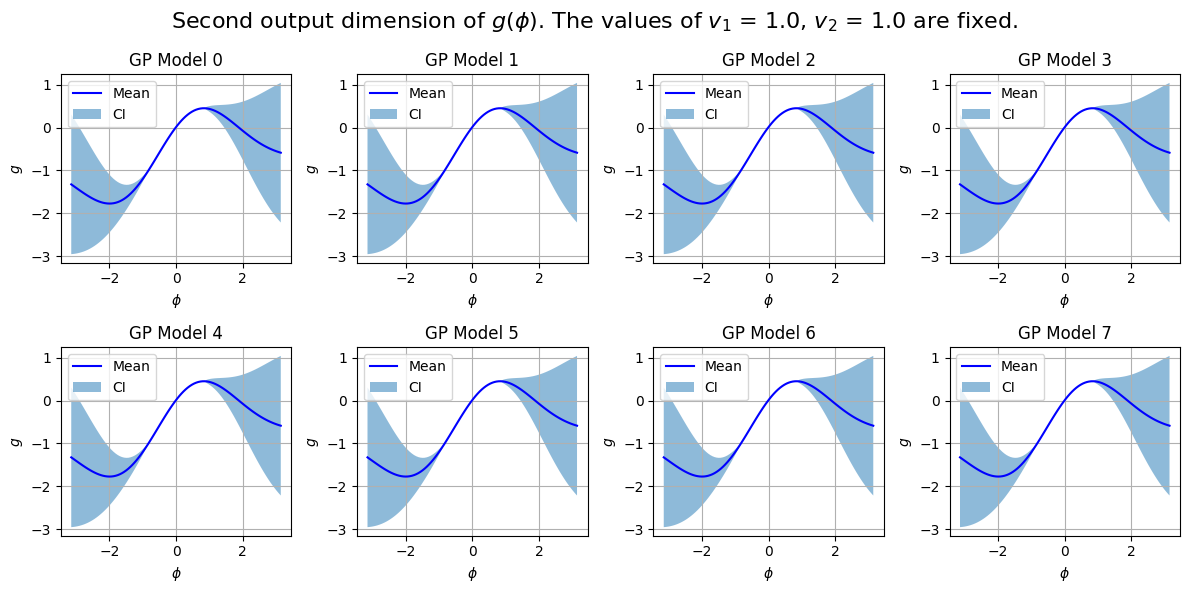

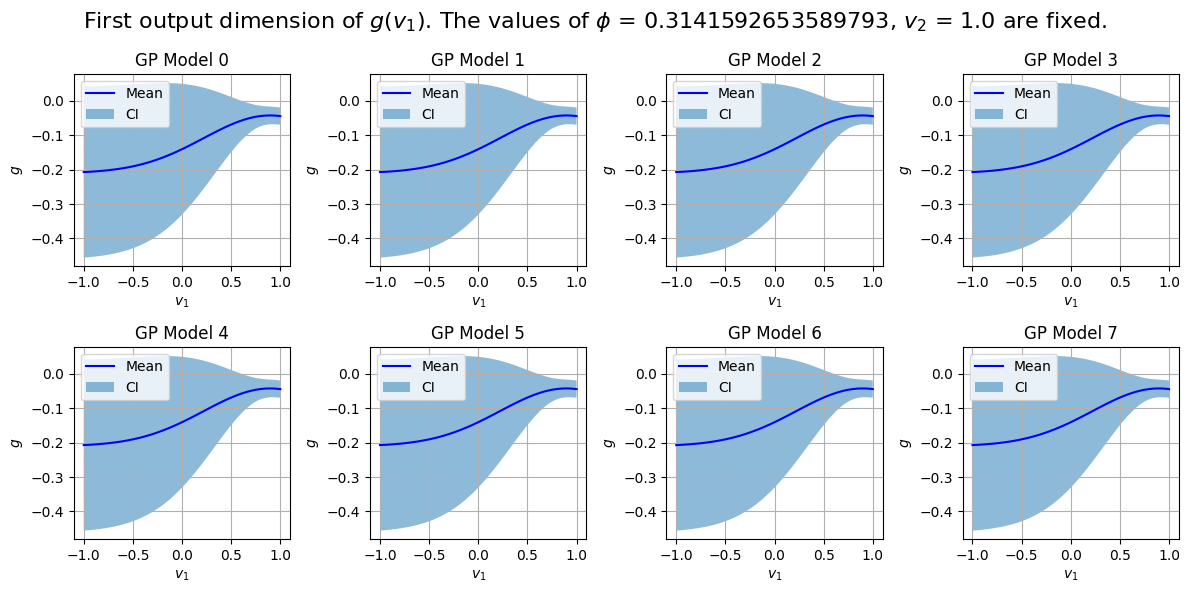

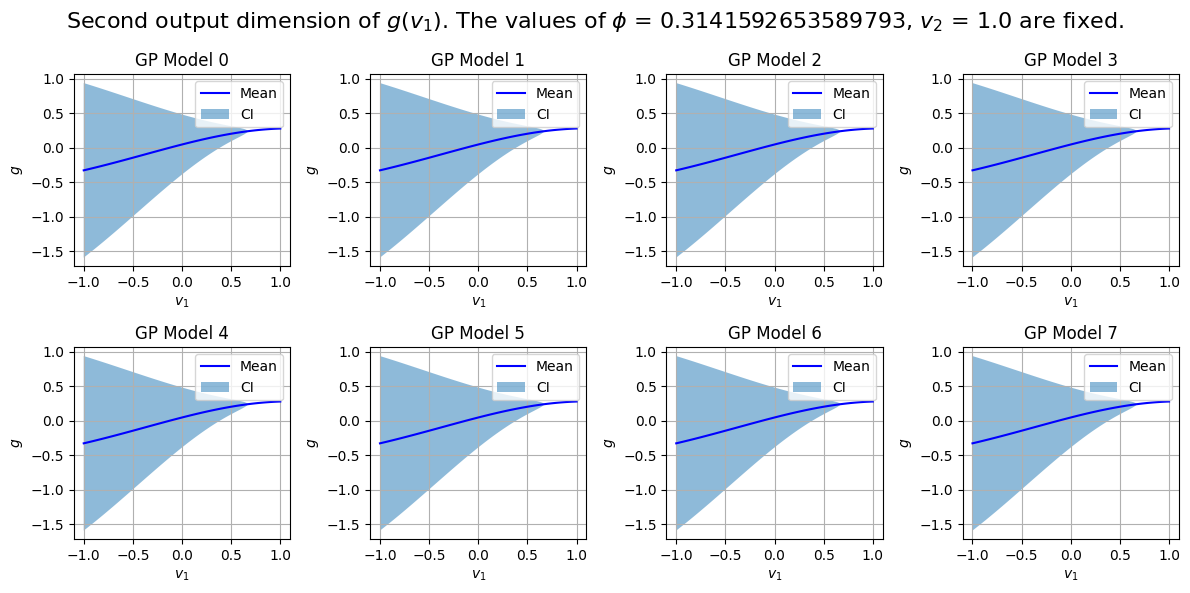

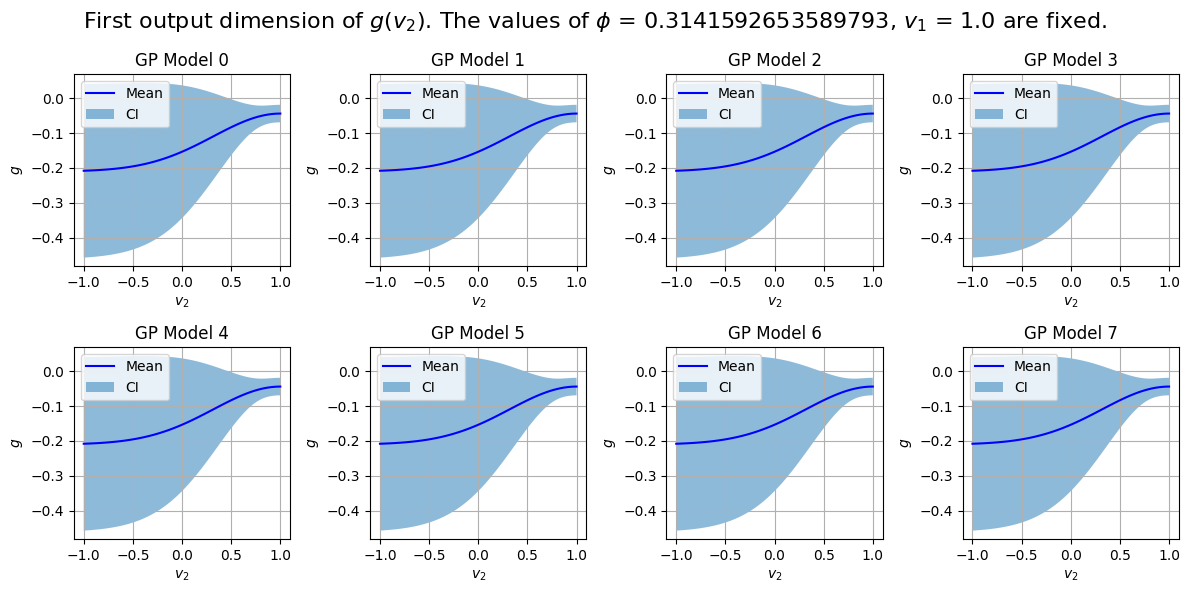

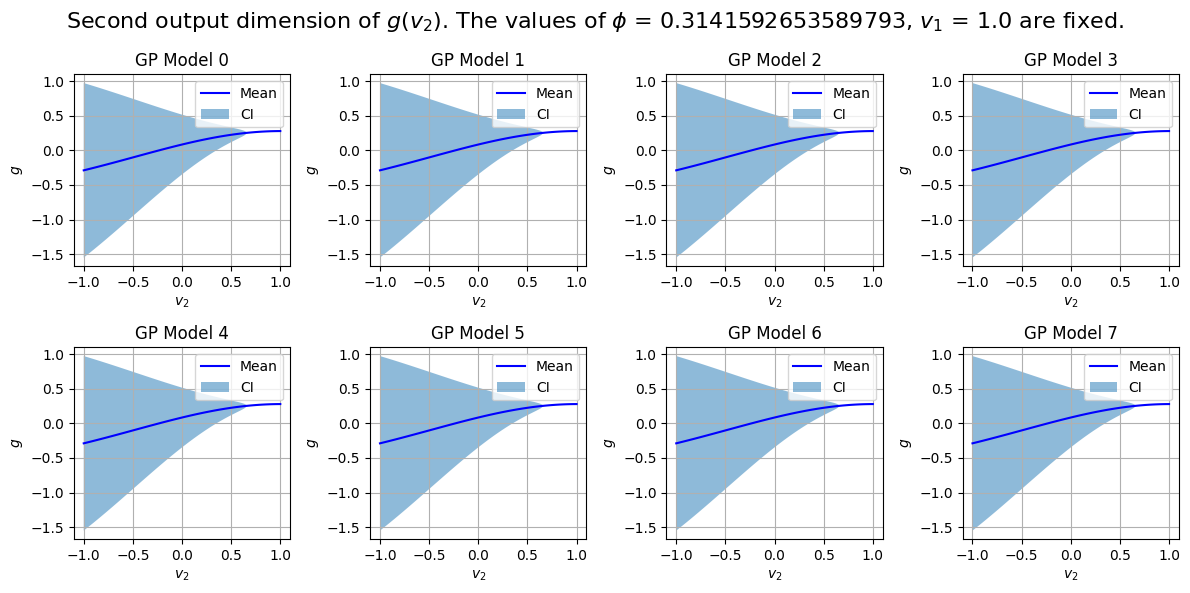

In [5]:
import torch
import gpytorch
import math
from matplotlib import pyplot as plt

# Function to plot GP predictions
def plot_gp_models(model, likelihood, var_range, fixed_vals, var_name, n_gp_models, output_dim, n_points=100):
    test_x = torch.zeros(n_points, 3)

    # Dictionary for LaTeX formatting
    var_latex_dict = {
        'phi': '$\phi$',
        'v1': '$v_1$',
        'v2': '$v_2$'
    }
    
    # Assign the range values to the appropriate variable
    if var_name == 'phi':
        test_x[:, 0] = torch.linspace(var_range[0], var_range[1], n_points)
        test_x[:, 1] = fixed_vals[0]  # v1
        test_x[:, 2] = fixed_vals[1]  # v2
    elif var_name == 'v1':
        test_x[:, 0] = fixed_vals[0]  # phi
        test_x[:, 1] = torch.linspace(var_range[0], var_range[1], n_points)
        test_x[:, 2] = fixed_vals[1]  # v2
    elif var_name == 'v2':
        test_x[:, 0] = fixed_vals[0]  # phi
        test_x[:, 1] = fixed_vals[1]  # v1
        test_x[:, 2] = torch.linspace(var_range[0], var_range[1], n_points)

    test_x = test_x.unsqueeze(0).repeat(n_gp_models, 1, 1)
    test_x = test_x.unsqueeze(0).repeat(2, 1, 1, 1)  # Add output dimension

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = likelihood(model(test_x))[output_dim]

    mean = observed_pred.mean.numpy()
    lower, upper = observed_pred.confidence_region()
    lower = lower.numpy()
    upper = upper.numpy()

    # Determine the number of rows and columns for subplots
    n_rows = 2
    n_cols = math.ceil(n_gp_models / 2)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 6))
    if n_gp_models == 1:
        axes = [axes]

    for i, ax in enumerate(axes.flat):
        x_values = test_x[0, 0, :, 0].numpy() if var_name == 'phi' else (test_x[0, 0, :, 1].numpy() if var_name == 'v1' else test_x[0, 0, :, 2].numpy())
        ax.plot(x_values, mean[i], 'b')
        ax.fill_between(x_values, lower[i], upper[i], alpha=0.5)
        ax.set_title(f'GP Model {i}')
        ax.set_xlabel(f'{var_latex_dict[var_name]}')
        ax.set_ylabel('$g$')
        ax.legend(['Mean', 'CI'])
        ax.grid()

    fixed_var_names = ['phi', 'v1', 'v2']
    fixed_var_names.remove(var_name)
    fixed_vals_str = ", ".join([f"{var_latex_dict[fixed_var_names[i]]} = {fixed_vals[i]}" for i in range(2)])
    g_dep_str = f"{var_latex_dict[var_name]}"

    output_dim_str = "First" if output_dim == 0 else "Second"
    fig.suptitle(f"{output_dim_str} output dimension of $g(${g_dep_str}$)$. The values of {fixed_vals_str} are fixed.", fontsize=16)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the title

    plt.tight_layout()
    plt.show()

# Define which range/point combination to plot
phi_range = (-torch.pi, torch.pi)
v1_range = (-1., 1.)
v2_range = (-1., 1.)
fixed_phi = torch.pi / 10
fixed_v1 = 1.0
fixed_v2 = 1.0

with gpytorch.settings.observation_nan_policy("fill"):
    # Plot GP models with varied phi, fixed v1, and fixed v2 for output dimension 0
    plot_gp_models(gp_models_as_batch, likelihood, phi_range, (fixed_v1, fixed_v2), 'phi', n_gp_models_in_batch, output_dim=0)

    # Plot GP models with varied phi, fixed v1, and fixed v2 for output dimension 1
    plot_gp_models(gp_models_as_batch, likelihood, phi_range, (fixed_v1, fixed_v2), 'phi', n_gp_models_in_batch, output_dim=1)

    # Plot GP models with varied v1, fixed phi, and fixed v2 for output dimension 0
    plot_gp_models(gp_models_as_batch, likelihood, v1_range, (fixed_phi, fixed_v2), 'v1', n_gp_models_in_batch, output_dim=0)

    # Plot GP models with varied v1, fixed phi, and fixed v2 for output dimension 1
    plot_gp_models(gp_models_as_batch, likelihood, v1_range, (fixed_phi, fixed_v2), 'v1', n_gp_models_in_batch, output_dim=1)

    # Plot GP models with varied v2, fixed phi, and fixed v1 for output dimension 0
    plot_gp_models(gp_models_as_batch, likelihood, v2_range, (fixed_phi, fixed_v1), 'v2', n_gp_models_in_batch, output_dim=0)

    # Plot GP models with varied v2, fixed phi, and fixed v1 for output dimension 1
    plot_gp_models(gp_models_as_batch, likelihood, v2_range, (fixed_phi, fixed_v1), 'v2', n_gp_models_in_batch, output_dim=1)


## 3. Update the last GP model in the batch

In [6]:
X_update = torch.tensor([[2.0,1.0,1.0],
                         [2.05,1.0,1.0],
                         [2.0,1.0,1.05],
                         [1.95,1.0,1.0]])
Y_update = generate_g_outputs(X_update, noise_size)
n_update_data_points = X_update.shape[0]


# Add ^points to the last GP model (index -1)
X_train_batch[:, -1, :n_offline_data + n_update_data_points, :] = torch.cat((X_update, X_train_offline)).tile([2,1,1])
Y_train_batch[0, -1, :n_offline_data + n_update_data_points] = torch.cat((Y_update, Y_train_offline))[:,0]
Y_train_batch[1, -1, :n_offline_data + n_update_data_points] = torch.cat((Y_update, Y_train_offline))[:,0]

with gpytorch.settings.observation_nan_policy("fill"):
    gp_models_as_batch.set_train_data(inputs=X_train_batch, targets=Y_train_batch)

## 4. Plot the updated batch

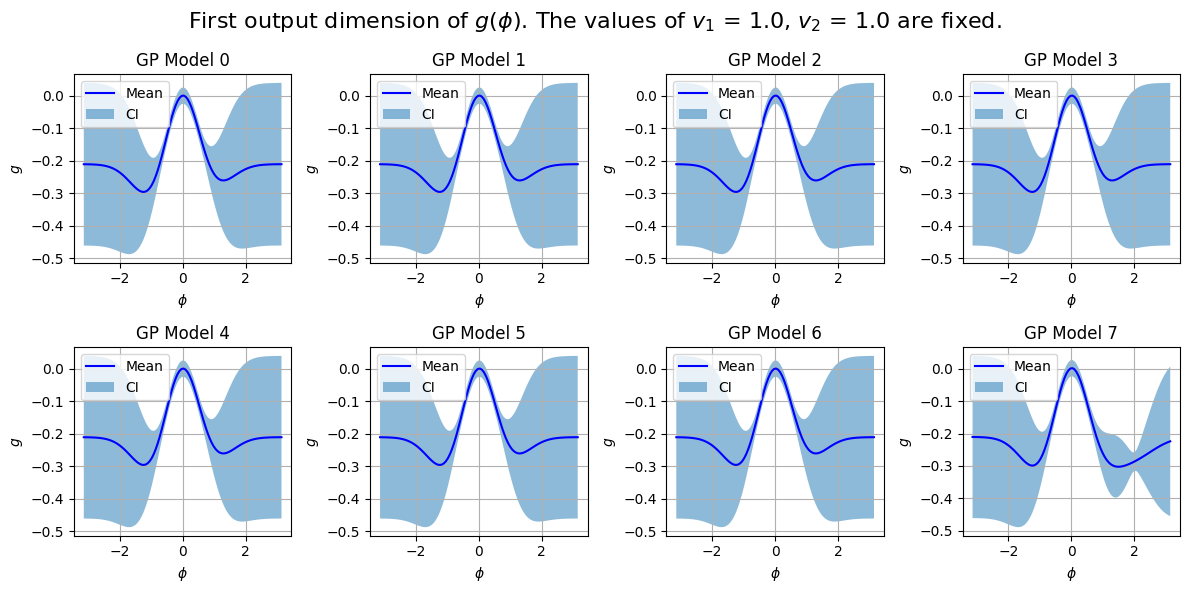

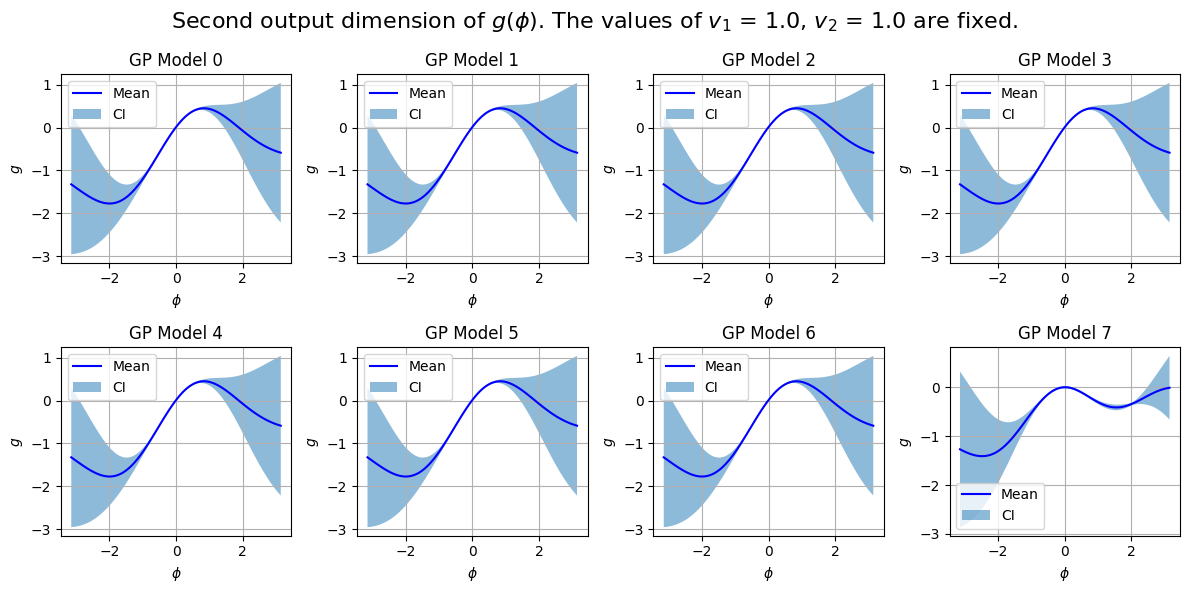

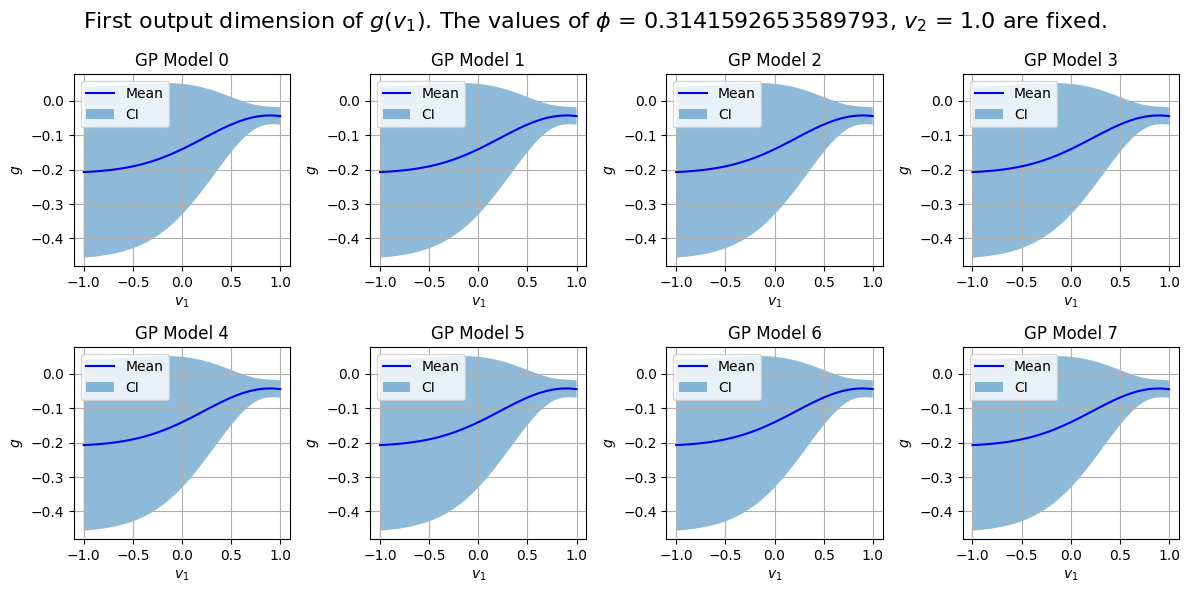

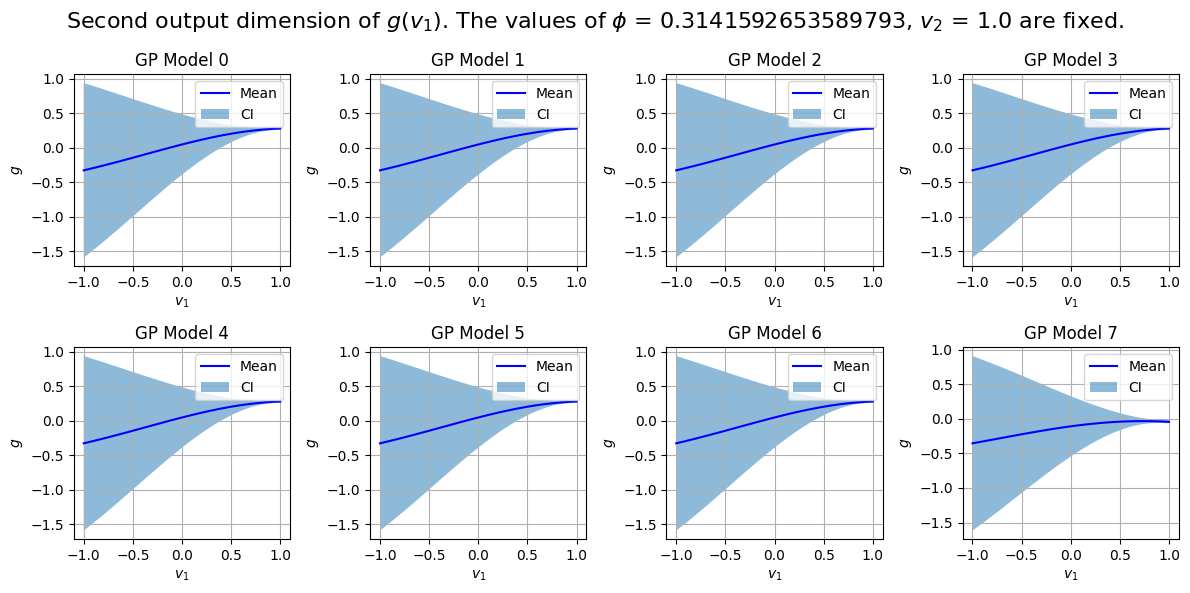

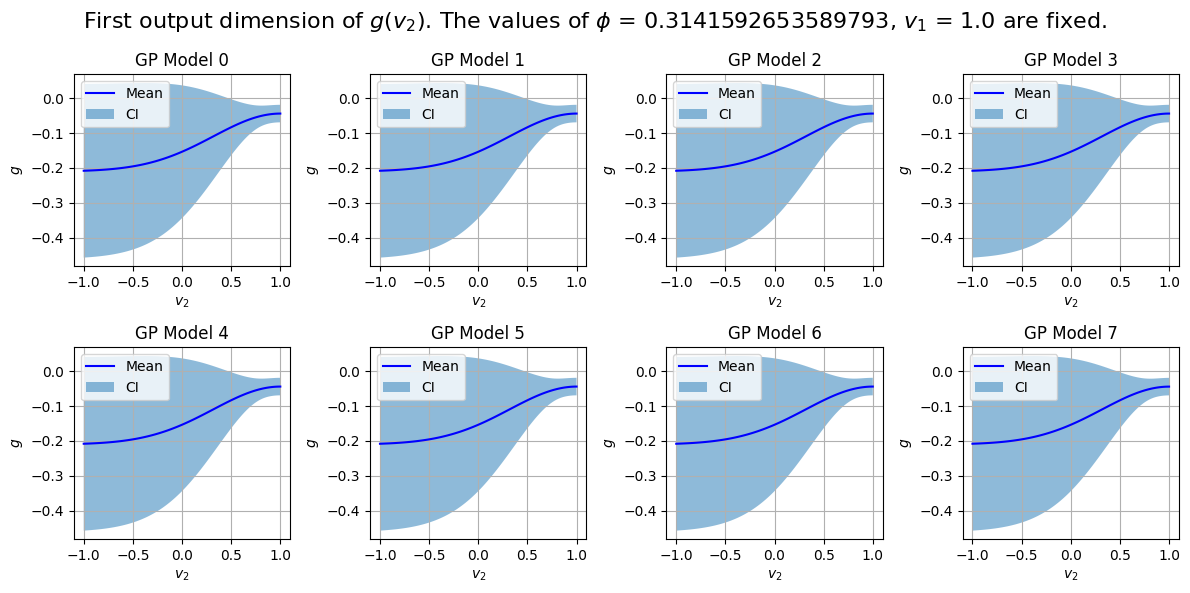

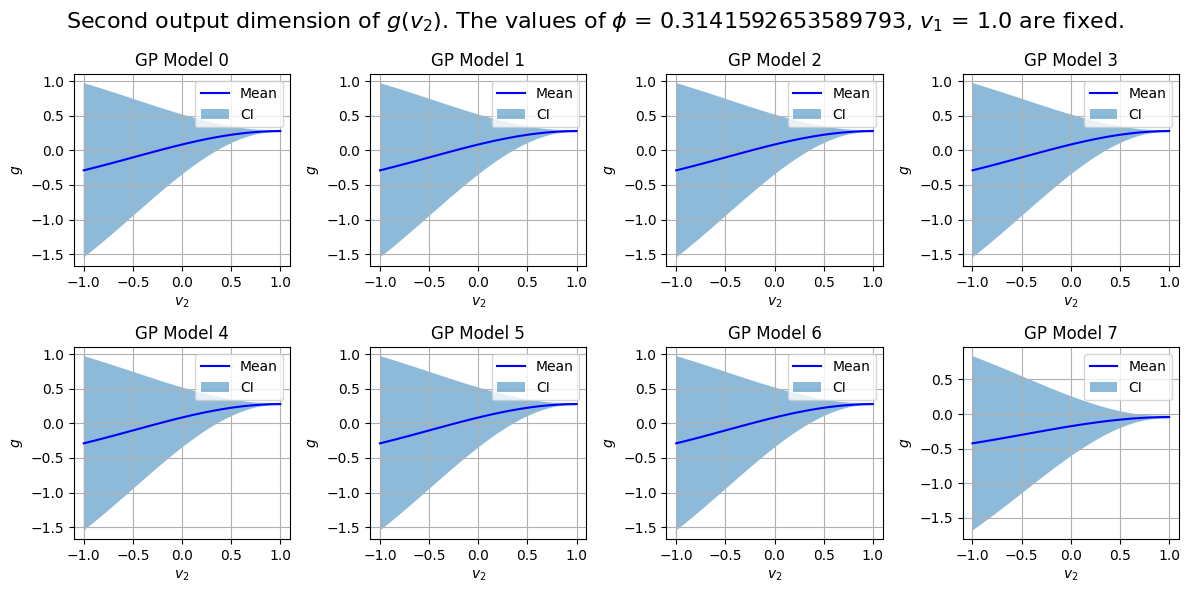

In [7]:
with gpytorch.settings.observation_nan_policy("fill"):
    # Plot GP models with varied phi, fixed v1, and fixed v2 for output dimension 0
    plot_gp_models(gp_models_as_batch, likelihood, phi_range, (fixed_v1, fixed_v2), 'phi', n_gp_models_in_batch, output_dim=0)

    # Plot GP models with varied phi, fixed v1, and fixed v2 for output dimension 1
    plot_gp_models(gp_models_as_batch, likelihood, phi_range, (fixed_v1, fixed_v2), 'phi', n_gp_models_in_batch, output_dim=1)

    # Plot GP models with varied v1, fixed phi, and fixed v2 for output dimension 0
    plot_gp_models(gp_models_as_batch, likelihood, v1_range, (fixed_phi, fixed_v2), 'v1', n_gp_models_in_batch, output_dim=0)

    # Plot GP models with varied v1, fixed phi, and fixed v2 for output dimension 1
    plot_gp_models(gp_models_as_batch, likelihood, v1_range, (fixed_phi, fixed_v2), 'v1', n_gp_models_in_batch, output_dim=1)

    # Plot GP models with varied v2, fixed phi, and fixed v1 for output dimension 0
    plot_gp_models(gp_models_as_batch, likelihood, v2_range, (fixed_phi, fixed_v1), 'v2', n_gp_models_in_batch, output_dim=0)

    # Plot GP models with varied v2, fixed phi, and fixed v1 for output dimension 1
    plot_gp_models(gp_models_as_batch, likelihood, v2_range, (fixed_phi, fixed_v1), 'v2', n_gp_models_in_batch, output_dim=1)